# Imports

In [558]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.stats import uniform
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)


In [559]:
df = pd.read_csv("../diabetes_binary_classification_data.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Data Split

In [560]:
X = df.copy().drop(["Diabetes_binary"], axis=1)
y = df.copy()["Diabetes_binary"].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=df['Diabetes_binary'], random_state=42)
y_train = y_train.values.ravel()

# Data Analysis

In [561]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190260 entries, 208779 to 73384
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                190260 non-null  float64
 1   HighChol              190260 non-null  float64
 2   CholCheck             190260 non-null  float64
 3   BMI                   190260 non-null  float64
 4   Smoker                190260 non-null  float64
 5   Stroke                190260 non-null  float64
 6   HeartDiseaseorAttack  190260 non-null  float64
 7   PhysActivity          190260 non-null  float64
 8   Fruits                190260 non-null  float64
 9   Veggies               190260 non-null  float64
 10  HvyAlcoholConsump     190260 non-null  float64
 11  AnyHealthcare         190260 non-null  float64
 12  NoDocbcCost           190260 non-null  float64
 13  GenHlth               190260 non-null  float64
 14  MentHlth              190260 non-null  float64
 15  P

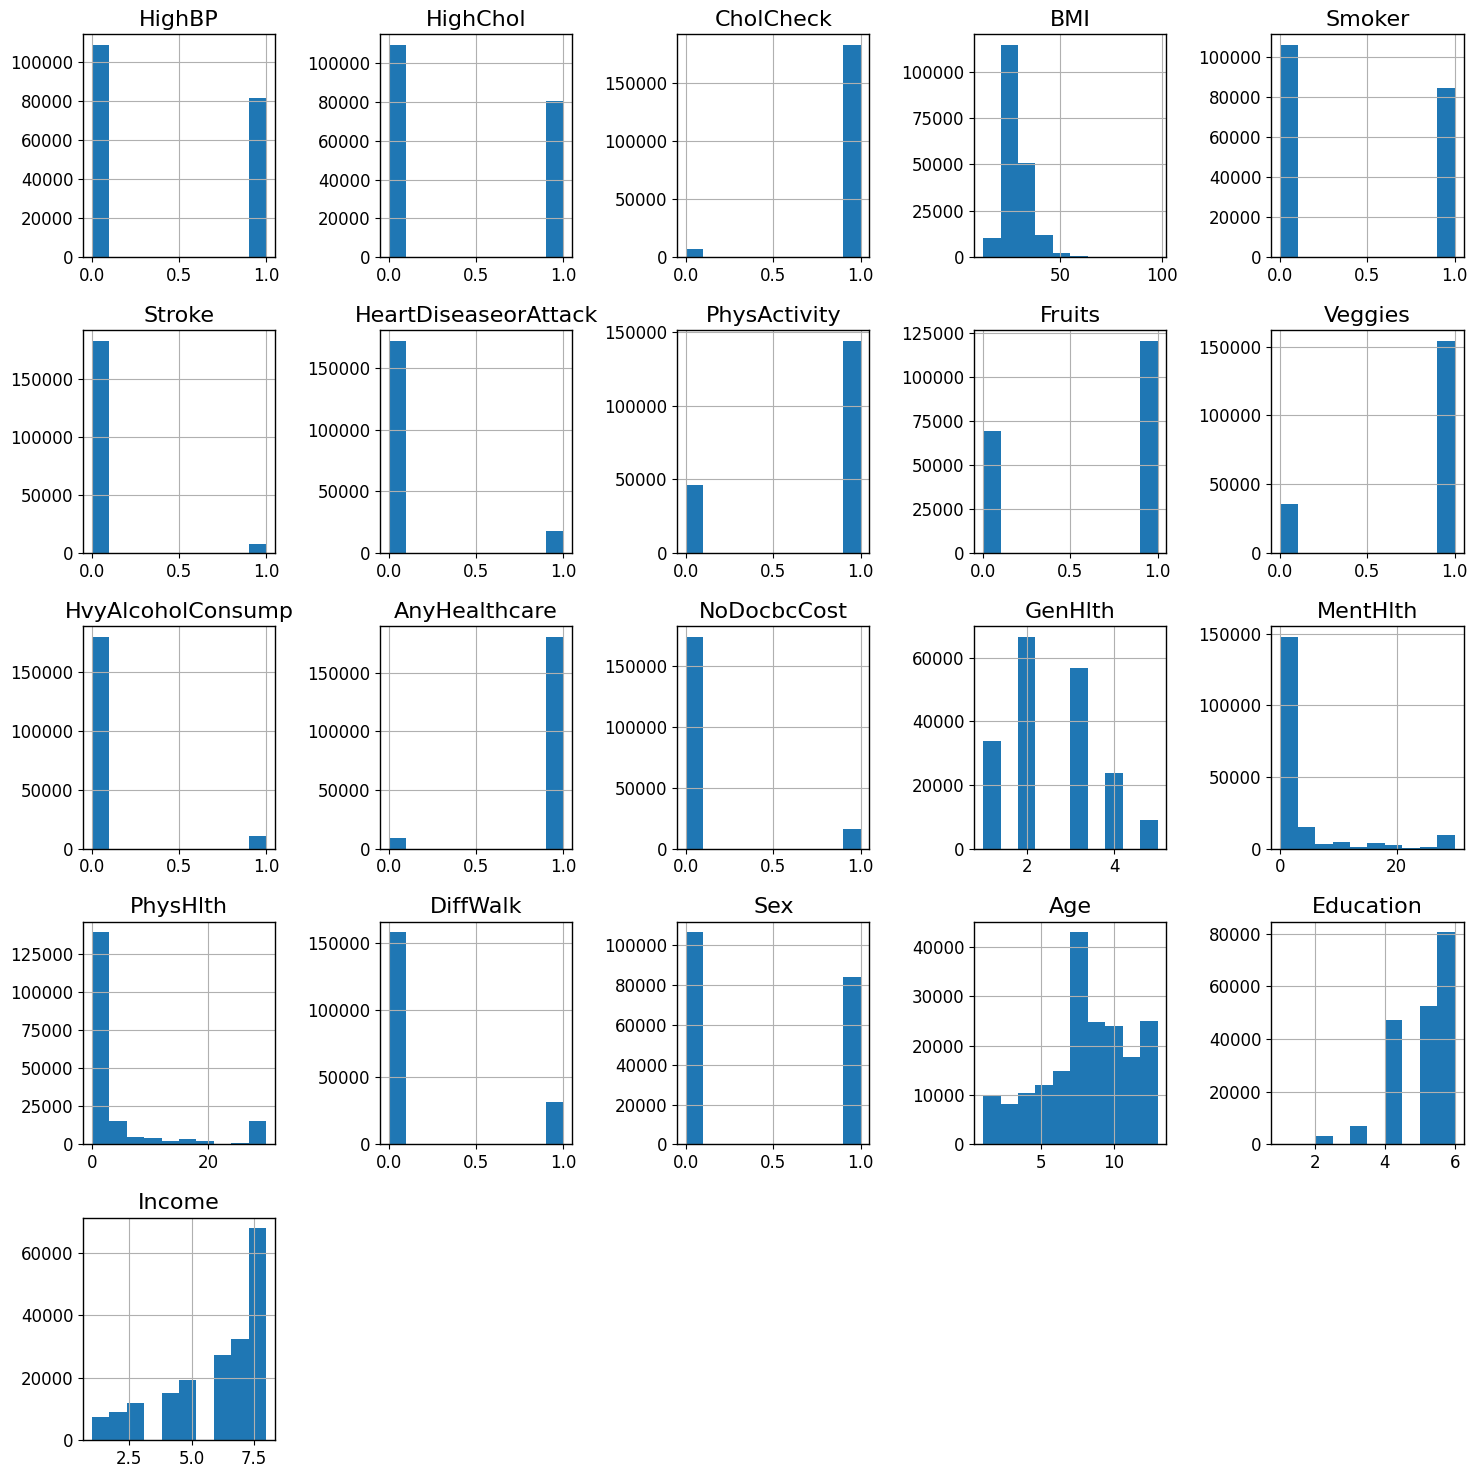

In [562]:
X_train.hist(figsize=(15, 15));

In [563]:
numeric_features = ['Age', 'BMI', 'GenHlth', 'PhysHlth', 'MentHlth', 'Education', 'Income']
log_right_features = ['PhysHlth', 'MentHlth', 'BMI']
log_left_features = ['Income', 'Education']

def log_name(transformer, feature_names_in):
    return feature_names_in

log_pipeline = make_pipeline(
    FunctionTransformer(np.log1p, feature_names_out=log_name), 
    StandardScaler())


def flip_and_log_name(transformer, feature_names_in):
    return feature_names_in

def flip_and_log(X):
    X = np.asarray(X)
    max = X.max()
    return np.log1p(max - X)

flip_and_log_pipeline = make_pipeline(
    FunctionTransformer(flip_and_log, feature_names_out=flip_and_log_name),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ('log_right', log_pipeline, log_right_features),
    ('log_left', flip_and_log_pipeline, log_left_features),
], remainder='passthrough')

In [564]:
corr = df.corr()
print(corr['Diabetes_binary'].sort_values(key=abs, ascending=False))


Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Income                 -0.163919
Education              -0.124456
PhysActivity           -0.118133
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
HvyAlcoholConsump      -0.057056
Veggies                -0.056584
Fruits                 -0.040779
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Name: Diabetes_binary, dtype: float64


# Dummy Classifier

In [565]:
dummy_clf = DummyClassifier(random_state=40, constant=True)
dummy_clf.fit(X_train, y_train)
print(any(dummy_clf.predict(X_train)))

print(cross_val_score(dummy_clf, X_train, y_train, cv=3, scoring='accuracy'))
y_pred_dummy = cross_val_predict(dummy_clf, X_train, y_train)

False
[0.86067487 0.86067487 0.8606591 ]


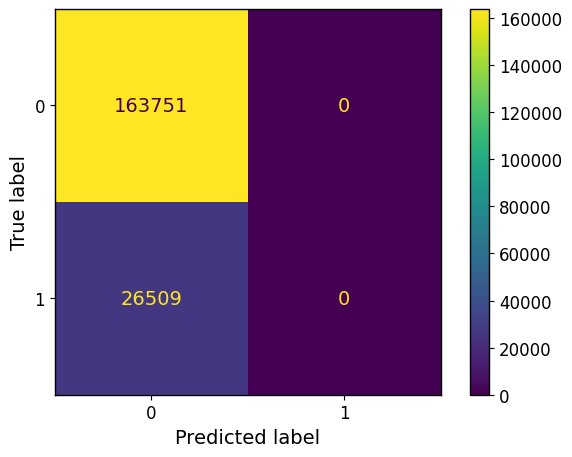

In [566]:
cm_dummy = confusion_matrix(y_train, y_pred_dummy)
ConfusionMatrixDisplay(cm_dummy).plot()

# SGD Classifier

In [569]:
sgdClassifier = make_pipeline(preprocessing, SGDClassifier(class_weight='balanced', random_state=42, eta0=0.01))

param_grid = {
    'sgdclassifier__penalty': ["l2", "l1", "elasticnet"],
    'sgdclassifier__alpha': uniform(0.0001, 0.01),
    'sgdclassifier__learning_rate': ['optimal', 'invscaling', 'constant']
    }

grid_search_sgd = RandomizedSearchCV(sgdClassifier, param_distributions=param_grid, cv=5, scoring='f1')

grid_search_sgd.fit(X_train, y_train)

print('Best params: ', grid_search_sgd.best_params_)
print('Best score: ', grid_search_sgd.best_score_)

Best params:  {'sgdclassifier__alpha': 0.0028622860234593472, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__penalty': 'elasticnet'}
Best score:  0.4409462971278787


In [570]:
# Apply the optimal hyperparameters and retrain the model
best_params_sgd = grid_search_sgd.best_params_
print(best_params_sgd)

sgdClassifier.set_params(
    sgdclassifier__penalty=best_params_sgd['sgdclassifier__penalty'],    
    sgdclassifier__alpha=best_params_sgd['sgdclassifier__alpha'],       
    sgdclassifier__learning_rate=best_params_sgd['sgdclassifier__learning_rate'],
)

sgdClassifier.fit(X_train, y_train)

y_pred_sgd = cross_val_predict(sgdClassifier, X_train, y_train)
y_scores_sgd = cross_val_predict(sgdClassifier, X_train, y_train, cv=3, method="decision_function")

{'sgdclassifier__alpha': 0.0028622860234593472, 'sgdclassifier__learning_rate': 'optimal', 'sgdclassifier__penalty': 'elasticnet'}


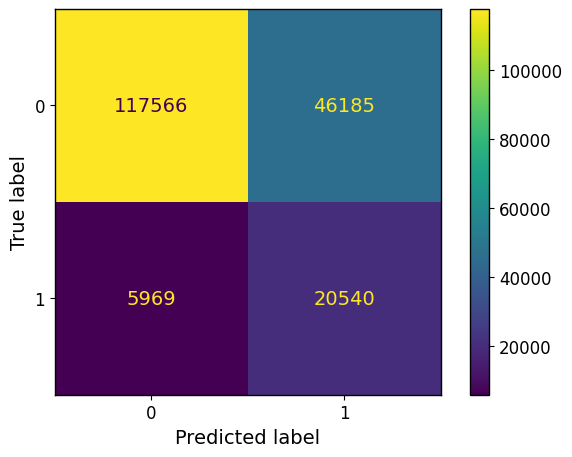

In [ ]:
cm_sgd = confusion_matrix(y_train, y_pred_sgd)
ConfusionMatrixDisplay(cm_sgd).plot()

In [572]:
print('precision: ', precision_score(y_train, y_pred_sgd))
print('recall: ', recall_score(y_train, y_pred_sgd))
print('f1: ', f1_score(y_train, y_pred_sgd))

precision:  0.30783064818284
recall:  0.7748311894073711
f1:  0.44061179398073663


thresholds [-5.50143866 -5.01477434 -4.74904408 ...  4.17428387  4.18500071
  4.3445584 ]


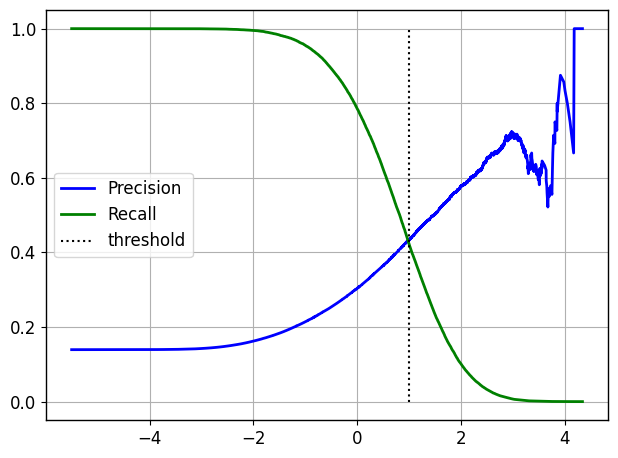

In [574]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_sgd)

print('thresholds', thresholds)

threshold = 1

plt.plot(thresholds, precisions[:-1], color="blue", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], color="green", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.grid()
plt.show()

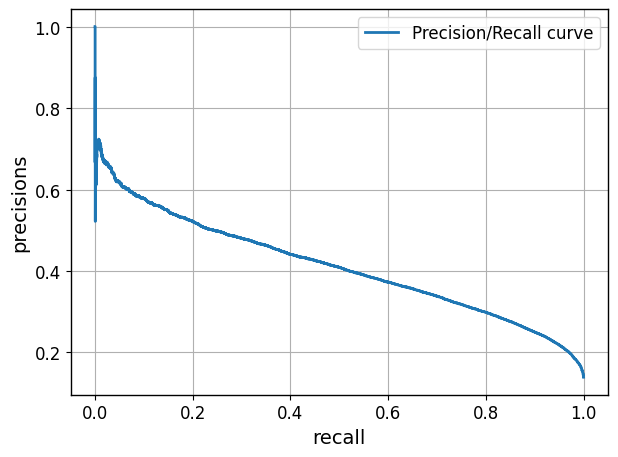

In [575]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('recall')
plt.ylabel('precisions')
plt.legend()
plt.grid()
plt.show()

In [576]:
idx_for_40_precision = (precisions >= 0.4).argmax()
threshold_for_40_precision = thresholds[idx_for_40_precision]

print('threshold for 40 precision: ', threshold_for_40_precision)

y_train_pred_40 = (y_scores_sgd >= threshold_for_40_precision)

precision_score(y_train, y_train_pred_40)
recall_at_40_precision = recall_score(y_train, y_train_pred_40)
print('recall at 40 precision: ', recall_at_40_precision)

precision = 0.4
recall = recall_at_40_precision

f1 = 2 * (precision * recall) / (precision + recall)
print(f1)

threshold for 40 precision:  0.7656421844656425
recall at 40 precision:  0.5206156399713305
0.45240651352613853


# K-Nearest Neighbors Classifier

In [577]:
knnClassifier = make_pipeline(preprocessing, KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__weights': ["uniform", "distance"],
    'kneighborsclassifier__n_neighbors': range(3, 11),
    'kneighborsclassifier__p': [1, 2]
    }

grid_search_knn = RandomizedSearchCV(knnClassifier, param_distributions=param_grid, cv=3, n_iter=5, scoring='f1', random_state=42)

grid_search_knn.fit(X_train, y_train)

print('Best params: ', grid_search_knn.best_params_)
print('Best score: ', grid_search_knn.best_score_)

Best params:  {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 6}
Best score:  0.27702430002044226


In [578]:
# Apply the optimal hyperparameters and retrain the model
best_params_knn = grid_search_knn.best_params_
print(best_params_knn)

knnClassifier.set_params(
    kneighborsclassifier__weights=best_params_knn['kneighborsclassifier__weights'],
    kneighborsclassifier__n_neighbors=best_params_knn['kneighborsclassifier__n_neighbors'],
    kneighborsclassifier__p=best_params_knn['kneighborsclassifier__p'],
)

knnClassifier.fit(X_train, y_train)

y_pred_knn = cross_val_predict(knnClassifier, X_train, y_train)
y_scores_knn = cross_val_predict(knnClassifier, X_train, y_train, cv=3, method="predict_proba")

{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 6}


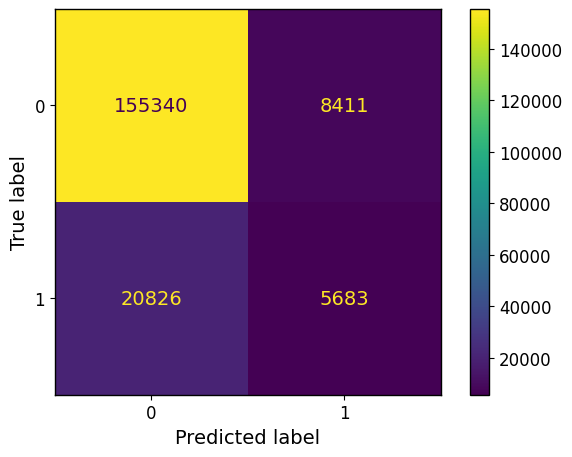

In [579]:
cm = confusion_matrix(y_train, y_pred_knn)

ConfusionMatrixDisplay(cm).plot()

In [580]:
print('precision: ', precision_score(y_train, y_pred_knn))
print('recall: ', recall_score(y_train, y_pred_knn))
print('f1: ', f1_score(y_train, y_pred_knn))

precision:  0.40322122889172696
recall:  0.21438002187936173
f1:  0.27993005442947566


# Random Forest Classifier

In [581]:
randomForestClassifier = make_pipeline(preprocessing, RandomForestClassifier(class_weight='balanced', random_state=42))

param_grid = {
    'randomforestclassifier__n_estimators': range(100, 110),
    'randomforestclassifier__max_depth': range(10, 20),
    'randomforestclassifier__min_samples_leaf': range(1, 5)
    }

grid_search_rfc = RandomizedSearchCV(randomForestClassifier, param_distributions=param_grid, cv=2, n_iter=10, scoring='f1', random_state=42)

grid_search_rfc.fit(X_train, y_train)

print('Best params: ', grid_search_rfc.best_params_)
print('Best score: ', grid_search_rfc.best_score_)

Best params:  {'randomforestclassifier__n_estimators': 106, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 16}
Best score:  0.4580963966685919


In [582]:
# Apply the optimal hyperparameters and retrain the model
best_params_rfc = grid_search_rfc.best_params_
print(best_params_rfc)

randomForestClassifier.set_params(randomforestclassifier__n_estimators=best_params_rfc['randomforestclassifier__n_estimators'],
                                  randomforestclassifier__max_depth=best_params_rfc['randomforestclassifier__max_depth'],
                                  randomforestclassifier__min_samples_leaf=best_params_rfc['randomforestclassifier__min_samples_leaf'])

randomForestClassifier.fit(X_train, y_train)

y_pred_rfc = cross_val_predict(randomForestClassifier, X_train, y_train)
y_scores_rfc = cross_val_predict(randomForestClassifier, X_train, y_train, cv=3, method="predict_proba")


{'randomforestclassifier__n_estimators': 106, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 16}


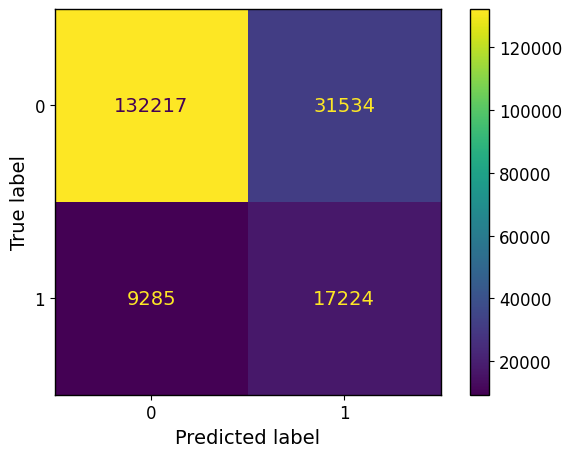

In [583]:
cm = confusion_matrix(y_train, y_pred_rfc)
ConfusionMatrixDisplay(cm).plot()

In [584]:
print('precision: ', precision_score(y_train, y_pred_rfc))
print('recall: ', recall_score(y_train, y_pred_rfc))
print('f1: ', f1_score(y_train, y_pred_rfc))

precision:  0.3532548504860741
recall:  0.649741597193406
f1:  0.4576773353528107


# ROC

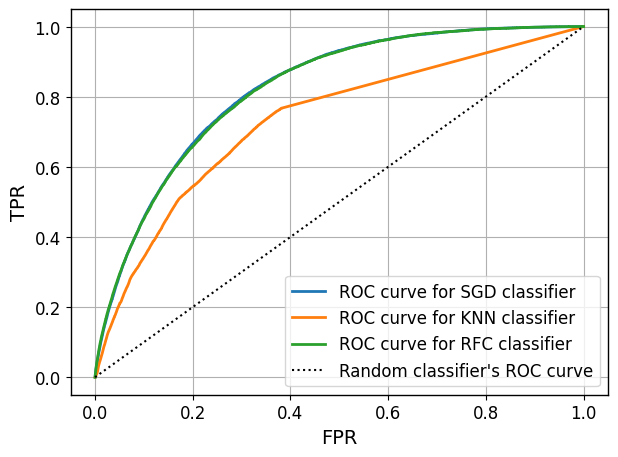

AUC:
SGD:  0.823
KNN:  0.731
RFC:  0.822


In [585]:
# For KNN
y_scores_knn_sliced = y_scores_knn[:, 1]  # probability of positive class
# For RFC
y_scores_rfc_sliced = y_scores_rfc[:, 1]  # probability of positive class

fpr_sgd, tpr_sgd, thresholds_rfc = roc_curve(y_train, y_scores_sgd)
fpr_knn, tpr_knn, thresholds_rfc = roc_curve(y_train, y_scores_knn_sliced)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train, y_scores_rfc_sliced)

plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label="ROC curve for SGD classifier")
plt.plot(fpr_knn, tpr_knn, linewidth=2, label="ROC curve for KNN classifier")
plt.plot(fpr_rfc, tpr_rfc, linewidth=2, label="ROC curve for RFC classifier")


plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

print('AUC:')
print('SGD: ', round(roc_auc_score(y_train, y_scores_sgd), 3))
print('KNN: ', round(roc_auc_score(y_train, y_scores_knn_sliced), 3))
print('RFC: ', round(roc_auc_score(y_train, y_scores_rfc_sliced), 3))

# F1 for all models

In [586]:
print('F1:')
print('SGD: ', round(f1_score(y_train, y_pred_sgd), 3))
print('KNN: ', round(f1_score(y_train, y_pred_knn), 3))
print('RFC: ', round(f1_score(y_train, y_pred_rfc), 3))

F1:
SGD:  0.441
KNN:  0.28
RFC:  0.458


# Evaluate on test-set

In [587]:
y_pred_sgd_test = sgdClassifier.predict(X_test)

y_pred_knn_test = knnClassifier.predict(X_test)

y_pred_rfc_test = randomForestClassifier.predict(X_test)


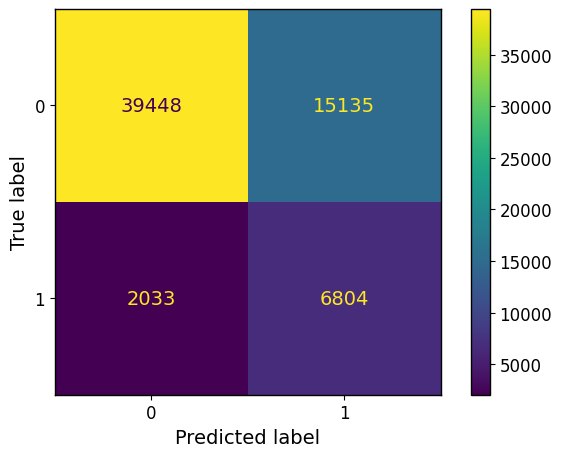

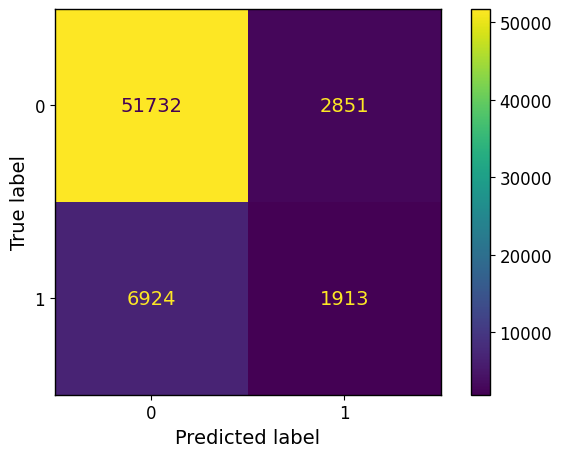

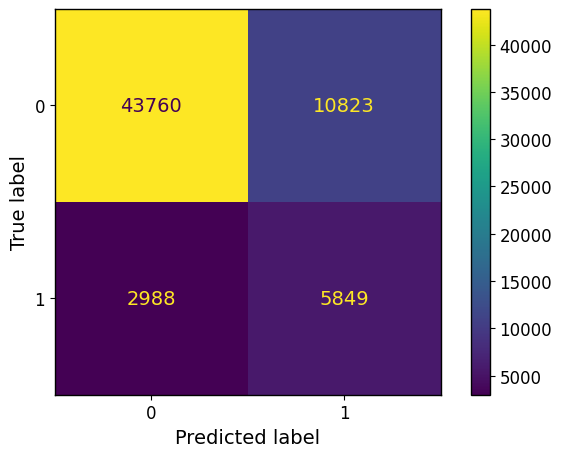

In [588]:
cm = confusion_matrix(y_test, y_pred_sgd_test)
ConfusionMatrixDisplay(cm).plot()

cm = confusion_matrix(y_test, y_pred_knn_test)
ConfusionMatrixDisplay(cm).plot()

cm = confusion_matrix(y_test, y_pred_rfc_test)
ConfusionMatrixDisplay(cm).plot()

In [589]:
print('F1:')
print('SGD:')
print('precision: ', round(precision_score(y_test, y_pred_sgd_test), 3))
print('recall: ', round(recall_score(y_test, y_pred_sgd_test), 3))
print('f1: ', round(f1_score(y_test, y_pred_sgd_test), 3))

print('\nKNN:')
print('precision: ', round(precision_score(y_test, y_pred_knn_test), 3))
print('recall: ', round(recall_score(y_test, y_pred_knn_test), 3))
print('f1: ', round(f1_score(y_test, y_pred_knn_test), 3))

print('\nRFC:')
print('precision: ', round(precision_score(y_test, y_pred_rfc_test), 3))
print('recall: ', round(recall_score(y_test, y_pred_rfc_test), 3))
print('f1: ', round(f1_score(y_test, y_pred_rfc_test), 3))

F1:
SGD:
precision:  0.31
recall:  0.77
f1:  0.442

KNN:
precision:  0.402
recall:  0.216
f1:  0.281

RFC:
precision:  0.351
recall:  0.662
f1:  0.459


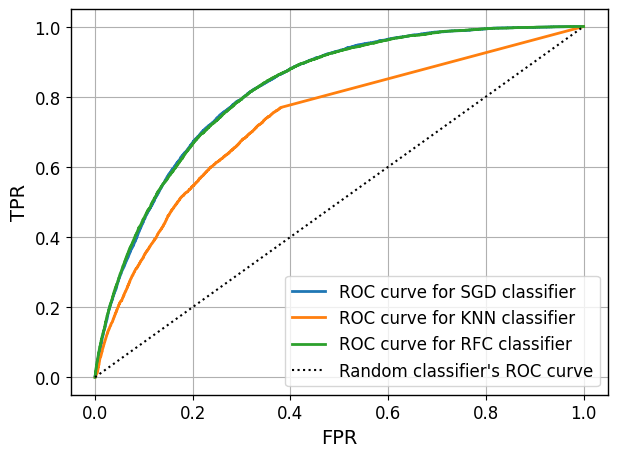

AUC:
SGD:  0.823
KNN:  0.733
RFC:  0.822


In [590]:
y_scores_sgd_test = sgdClassifier.decision_function(X_test)
y_scores_knn_test = knnClassifier.predict_proba(X_test)
y_scores_rfc_test = randomForestClassifier.predict_proba(X_test)

y_scores_knn_sliced = y_scores_knn_test[:, 1]  # probability of positive class
y_scores_rfc_sliced = y_scores_rfc_test[:, 1]  # probability of positive class

fpr_sgd, tpr_sgd, thresholds_rfc = roc_curve(y_test, y_scores_sgd_test)
fpr_knn, tpr_knn, thresholds_rfc = roc_curve(y_test, y_scores_knn_sliced)
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_scores_rfc_sliced)

plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label="ROC curve for SGD classifier")
plt.plot(fpr_knn, tpr_knn, linewidth=2, label="ROC curve for KNN classifier")
plt.plot(fpr_rfc, tpr_rfc, linewidth=2, label="ROC curve for RFC classifier")

plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

print('AUC:')
print('SGD: ', round(roc_auc_score(y_test, y_scores_sgd_test), 3))
print('KNN: ', round(roc_auc_score(y_test, y_scores_knn_sliced), 3))
print('RFC: ', round(roc_auc_score(y_test, y_scores_rfc_sliced), 3))